In [1]:
import warnings

warnings.filterwarnings("ignore")

import sys
import os

# 配置搜索路径
sys.path.append("./")
sys.path.append("../")
sys.path.append("../../")
import backtrader as bt
import pandas as pd
import pprint
import sqlite3
import math
from tqdm import tqdm
from datetime import datetime
from strategies.ml_based_strategy import CustomMLStrategy
# from strategies.ml_based_strategy_v2 import CustomMLStrategy
from backtest_utils import CustomCommissionSchema, CustomAnalyzer
from Share.database.downloader.downloader_base import DownloaderBase
import Share.database.database_config as db_config

In [2]:
BACKTEST_INITIAL_CASH = 100000  # 初始化资金
BACKTEST_INDEX_SYMBOLS = "000905"  # 【选股】策略的对比基准=指数index，【择时】策略的对比基准=单股自身
# BACKTEST_FIX_SIZER = 500

In [3]:
model_pred_list = []
pred_dir = f'./backtest_data/{BACKTEST_INDEX_SYMBOLS}/'
for file_name in sorted(os.listdir(pred_dir)):
    print(file_name)
    model_pred_list.append(pd.read_pickle(pred_dir+f'{file_name}'))
# model_pred_df = pd.concat(model_pred_list)
model_pred_df = model_pred_list[0]
# model_pred_df['stock_code'] = model_pred_df['stock_code'].map(lambda x: str(x).zfill(6))

stock_selection_results_20200101.pkl


In [4]:
# def get_model_prediction(dataframe, n=5):
#     def get_stock_for_buy(group):
#         filtered_group = group[group["label_pred"] > 0.0]
#         top_n = filtered_group.nlargest(n, "label_pred")
#         return top_n.to_dict("records")

#     def get_stock_for_sell(group):
#         filtered_group = group[group["label_pred"] < 0.0]
#         bottom_n = filtered_group.nsmallest(n, "label_pred")
#         return bottom_n.to_dict("records")

#     model_prediction = dataframe
#     model_prediction["stock_code"] = model_prediction["stock_code"].map(lambda x: str(x).zfill(6))
#     stock_for_buy = model_prediction.groupby("datetime").apply(get_stock_for_buy).to_dict()
#     stock_for_sell = model_prediction.groupby("datetime").apply(get_stock_for_sell).to_dict()
#     return stock_for_buy, stock_for_sell

# buy_df, sell_df = get_model_prediction(model_pred_df)

In [5]:
# 构建数据里表
BACKTEST_STOCK_SYMBOLS = model_pred_df['stock_code'].unique().tolist()
BACKTEST_START_DATE = datetime.strptime(model_pred_df['datetime'].min(), "%Y-%m-%d").strftime("%Y%m%d")  # 回测开始日期
BACKTEST_END_DATE = datetime.strptime(model_pred_df['datetime'].max(), "%Y-%m-%d").strftime("%Y%m%d")  # 回测结束日期
print(f'Start: {BACKTEST_START_DATE}, End: {BACKTEST_END_DATE}')
BACKTEST_DATETIME_INDEX = pd.date_range(start=BACKTEST_START_DATE, end=BACKTEST_END_DATE, freq='B')

Start: 20200102, End: 20231221


In [6]:
# 初始化db_downloader
db_conn = sqlite3.connect("../../Share/database/hh_quant.db")
db_downloader = DownloaderBase(db_conn=db_conn, db_config=db_config)

In [7]:
cerebro = bt.Cerebro()

In [8]:
print("开始设置回测基础参数...")
cerebro.broker.setcash(BACKTEST_INITIAL_CASH)  # 配置初始资金量
cerebro.broker.addcommissioninfo(CustomCommissionSchema())  # 配置自定义的佣金类型
cerebro.broker.set_slippage_perc(perc=0.0001) # 配置自定义的滑点类型

开始设置回测基础参数...


In [9]:
print("开始添加回测股票数据...")
for stock_symbol in tqdm(BACKTEST_STOCK_SYMBOLS):
    stock_data = db_downloader._download_stock_history_info(stock_symbol, start_date=BACKTEST_START_DATE, end_date=BACKTEST_END_DATE)
    if not stock_data.empty:
        stock_data = stock_data[["datetime", "open", "high", "low", "close", "volume"]]
        stock_data["datetime"] = pd.to_datetime(stock_data["datetime"])
        stock_data = stock_data.set_index("datetime").reindex(BACKTEST_DATETIME_INDEX).fillna(method='ffill')
        stock_data_feeds = bt.feeds.PandasData(dataname=stock_data)  # 构建回测数据Feeds流
        cerebro.adddata(stock_data_feeds, name=stock_symbol)  # 添加回测数据

开始添加回测股票数据...


100%|██████████| 428/428 [00:02<00:00, 205.45it/s]


In [10]:
print("开始添加基准数据...")
benchmark_data = db_downloader._download_index_history_info(BACKTEST_INDEX_SYMBOLS, start_date=BACKTEST_START_DATE, end_date=BACKTEST_END_DATE)
benchmark_data = benchmark_data[["datetime", "open", "high", "low", "close", "volume"]]
benchmark_data["datetime"] = pd.to_datetime(benchmark_data["datetime"])
benchmark_data = benchmark_data.set_index("datetime").reindex(BACKTEST_DATETIME_INDEX).fillna(method='ffill')
benchmark_name = f"benchmark_{BACKTEST_INDEX_SYMBOLS}"
benchmark_data_feeds = bt.feeds.PandasData(dataname=benchmark_data)  # 构建基准数据Feeds流
cerebro.adddata(benchmark_data_feeds, name=benchmark_name)  # 添加基准数据

开始添加基准数据...


In [11]:
print("开始添加策略...")
strategy_params = {
        "model_pred_dataframe": model_pred_df,
        "benchmark": benchmark_name,
        "top_n": 3,
        "max_cash_per_instrument": 0.1,
        "min_size": 100,
    }
cerebro.addstrategy(CustomMLStrategy, **strategy_params)

开始添加策略...


0

In [12]:
print("开始添加分析器...")
cerebro.addanalyzer(bt.analyzers.DrawDown, _name="drawdown")  # 添加最大回撤的分析器，后续customAnalyzer中需要用到
cerebro.addanalyzer(CustomAnalyzer, _name="custom_analyzer")  # 添加自定义的分析器

开始添加分析器...


In [13]:
# print("开始添加观察器...")
# cerebro.addobserver(bt.observers.Benchmark, data=benchmark_data_feeds, timeframe=bt.TimeFrame.NoTimeFrame)  # 添加基准对比观察器

In [14]:
print("开始运行回测...")
# 运行回测
results = cerebro.run()
# 打印初始资金
print(f"Start Portfolio Value: {BACKTEST_INITIAL_CASH}")
# 打印最终资金
print(f"Final Portfolio Value: {cerebro.broker.getvalue()}")

开始运行回测...


启动基准对比...
回测数据共: 428
current_date: 2020-01-02 ================================================================================
today_buy_stocks: ['600004', '603826', '603056']
today_sell_stocks: ['300748', '300207', '300474']
current_cash: 100000.0
2020-01-03 买入执行, 引用: 1, 价格: 38.20, 成本: 10046.66, 手续费: 5.00, 数量: 263.00, 股票: 600004
2020-01-03 买入执行, 引用: 2, 价格: 21.50, 成本: 9974.91, 手续费: 5.00, 数量: 464.00, 股票: 603826
2020-01-03 买入执行, 引用: 3, 价格: 11.56, 成本: 9999.97, 手续费: 5.00, 数量: 865.00, 股票: 603056
current_date: 2020-01-03 ================================================================================
today_buy_stocks: ['603056', '600004', '000893']
today_sell_stocks: ['300748', '300474', '300207']
current_cash: 69963.46544673001
2020-01-06 买入执行, 引用: 4, 价格: 11.59, 成本: 9991.75, 手续费: 5.00, 数量: 862.00, 股票: 603056
2020-01-06 买入执行, 引用: 5, 价格: 37.39, 成本: 9909.38, 手续费: 5.00, 数量: 265.00, 股票: 600004
2020-01-06 买入执行, 引用: 6, 价格: 9.66, 成本: 9258.08, 手续费: 5.00, 数量: 958.00, 股票: 000893
2020-01-06 卖出执行, 引用: 7

开始打印回测相关指标...
Start Portfolio Value: 100000
Final Portfolio Value: 147968.04049026244
{'其他': {'亏损次数': 426,
        '夏普比率': 0.5954,
        '日均超额收益': 0.0004,
        '日胜率': 0.4754,
        '最大回撤': 19.4215,
        '最大回撤区间': 187,
        '盈亏比': 1.7185,
        '盈利次数': 303,
        '索提诺比率': 0.8572,
        '胜率': 0.4156,
        '贝塔': 0.6571,
        '超额收益': 0.4848,
        '超额收益夏普比率': 0.6104,
        '阿尔法': 0.0004},
 '基准': {'基准年化收益': -0.0012, '基准收益': -0.0051, '基准波动率': 0.1899},
 '策略': {'策略年化收益': 0.1, '策略收益': 0.4797, '策略波动率': 0.1908}}


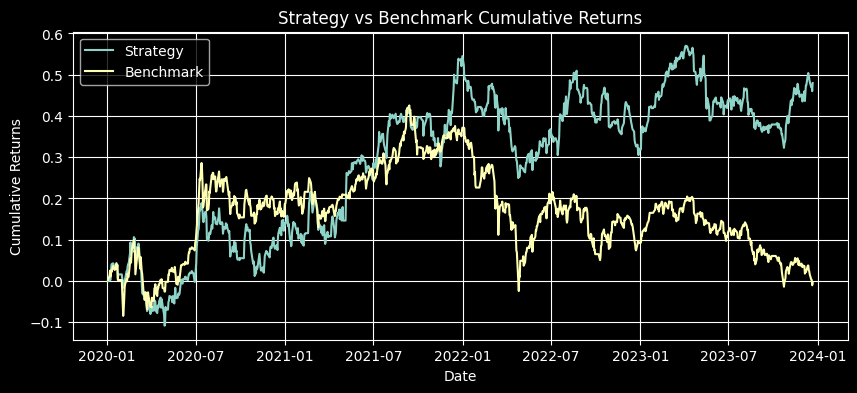

In [15]:
print("开始打印回测相关指标...")
# 打印初始资金
print(f"Start Portfolio Value: {BACKTEST_INITIAL_CASH}")
# 打印最终资金
print(f"Final Portfolio Value: {cerebro.broker.getvalue()}")

def plot_strategy_benchmark_returns(strategy_returns, benchmark_returns):
    import matplotlib.pyplot as plt
    # 检查index是否一致以保证对齐
    if not strategy_returns.index.equals(benchmark_returns.index):
        raise ValueError("Indexes of strategy_returns and benchmark_returns must match")
    # 计算累积收益率
    strategy_cumulative_returns = (1 + strategy_returns).cumprod() - 1
    benchmark_cumulative_returns = (1 + benchmark_returns).cumprod() - 1
    # 绘制累积收益率曲线
    plt.figure(figsize=(10,4))
    plt.plot(strategy_cumulative_returns, label='Strategy')
    plt.plot(benchmark_cumulative_returns, label='Benchmark')
    # 添加标题和标签
    plt.title('Strategy vs Benchmark Cumulative Returns')
    plt.xlabel('Date')
    plt.ylabel('Cumulative Returns')
    # 显示图例
    plt.legend()
    # 显示网格
    plt.grid(True)
    # 显示绘制的图形
    plt.show()

custom_analysis = results[0].analyzers.custom_analyzer.get_analysis()
format_analysis_result = {"基准": {}, "策略": {}, "其他": {}}
for key, value in custom_analysis.items():
    if key.startswith("基准"):
        format_analysis_result["基准"][key] = round(value, 4)
    elif key.startswith("策略"):
        format_analysis_result["策略"][key] = round(value, 4)
    else:
        format_analysis_result["其他"][key] = round(value, 4)
pprint.pprint(format_analysis_result)

strategy_returns = pd.Series(results[0].analyzers.custom_analyzer.get_strategy_returns(), index=benchmark_data.index[1:])
benchmark_returns = pd.Series(results[0].analyzers.custom_analyzer.get_benchmark_returns(), index=benchmark_data.index[1:])
plot_strategy_benchmark_returns(strategy_returns, benchmark_returns)

In [16]:
# %tensorboard --logdir ./logs/fit

In [17]:
annual_strategy_returns = strategy_returns.resample('Y').apply(lambda x: (1 + x).prod() - 1)
annual_benchmark_returns = benchmark_returns.resample('Y').apply(lambda x: (1 + x).prod() - 1)
annual_returns = pd.concat([annual_strategy_returns, annual_benchmark_returns], axis=1)
annual_returns.columns = ['Strategy', 'Benchmark']
annual_returns['Gap'] = annual_returns['Strategy'] - annual_returns['Benchmark']
annual_returns

,Strategy,Benchmark,Gap
2020-12-31,0.139641,0.186536,-0.046895
2021-12-31,0.355649,0.155846,0.199803
2022-12-31,-0.146354,-0.203133,0.056778
2023-12-31,0.121954,-0.089642,0.211597


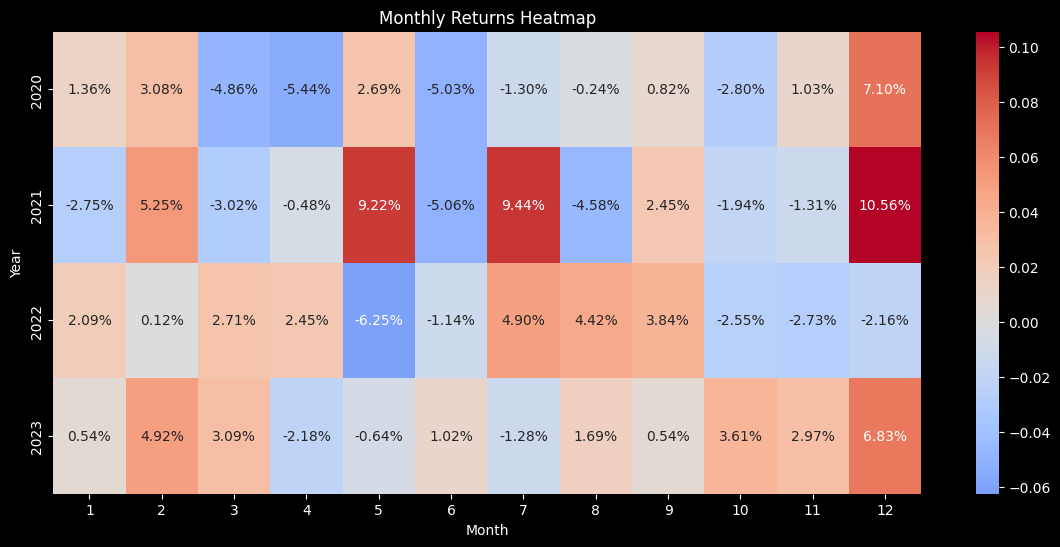

In [18]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# 假设 monthly_returns 是一个包含月度收益率的Series，并且它的索引是DateTimeIndex
# 如果它不是DataFrame，我们先将其转换成DataFrame
strategy_monthly_returns = strategy_returns.resample('M').apply(lambda x: (1 + x).prod() - 1)
benchmark_monthly_returns = benchmark_returns.resample('M').apply(lambda x: (1 + x).prod() - 1)
gap_monthly = strategy_monthly_returns - benchmark_monthly_returns

monthly_returns_df = gap_monthly.to_frame(name='收益率差')

# 创建新的列来代表年份和月份
monthly_returns_df['Year'] = monthly_returns_df.index.year
monthly_returns_df['Month'] = monthly_returns_df.index.month

# 使用pivot方法来创建适合热力图的DataFrame
pivot_table = monthly_returns_df.pivot(index='Year', columns='Month', values='收益率差')

# 使用Seaborn绘制热力图
plt.figure(figsize=(14, 6))
sns.heatmap(pivot_table, annot=True, fmt=".2%", cmap='coolwarm', center=0)
plt.title('Monthly Returns Heatmap')
plt.ylabel('Year')
plt.xlabel('Month')
plt.show()


在交易策略中控制最大回撤是风险管理的一个重要方面。最大回撤是指投资组合在某一时间区间内从峰值下降到谷底的最大损失。它是衡量投资风险的关键指标之一。以下是一些可以帮助控制或减少最大回撤的方法：

资金管理:

使用固定百分比的仓位大小，这样即使账户值处于下降趋势，你也会损失较少的资金。
定义最大仓位大小确保不要用太大一部分的资金在单一交易中。
止损策略:

使用止损单可以限制单个交易的损失。
考虑使用动态止损策略，如移动止损，当你的交易盈利时，止损线移动以锁定利润。
减少杠杆:

杠杆可以放大盈利，也会放大亏损。减少杠杆使用将减少潜在的最大回撤。
分散投资:

不要将资金集中在单一市场或资产。通过跨不同市场和资产分散投资，降低整体风险。
趋势跟踪:

遵循市场趋势进行交易。趋势跟踪策略通常涉及在价格上涨时购买，在价格下跌时卖出或做空。
交易尺寸的动态调整:

根据最近的账户表现调整交易尺寸。如果你遇到了一系列的亏损，减小交易规模直到表现改善。
使用Trailing Stop:

Trailing Stop（跟踪止损）可以在交易盈利时保护一部分利润，并在市场逆转时退出市场。
策略评估:

定期评估交易策略的有效性，并在必要时作出调整。
最大回撤控制通常需要在策略设计的早期就考虑进去，因此策略的回测和实时执行都需要考虑到最大回撤的控制方法。确保在实际交易前，已经通过历史数据测试了策略的最大回撤，并对其感到满意。此外，良好的心理和情绪控制，以及遵循既定的交易计划，也是减小最大回撤的关键因素。